In [1]:
from tsai.basics import *
import json
import numpy as np
import fastai
import fastai.tabular
from fastai.vision.all import *
from CNN import *
from tsai.data.metadatasets import TSMetaDataset, TSMetaDatasets
import matplotlib.pyplot as plt
from mocatml.utils import *
from mocatml.data import *

In [2]:
with open("data_config.json", "r") as outfile:
    data = json.load(outfile, strict=False)
extent = list(data['extent'])
data_numpy = np.load('data.npy')

d, n_epochs, window_size, batch_size = 256, 35, 60, 8192
num_sim = 100
model = AutoEncoder(d)
load_model(f'model/d_{d}_epoch_{n_epochs}.pkl', model, None)

In [3]:
with open(f'model/indices_d_{d}_epoch_{n_epochs}.txt', "r") as f:
    indices = f.read().split()
    
split = float(indices[0])
indices = [int(i) for i in indices[1:]]

train_indices = indices[:int(split * num_sim)]
val_indices = indices[int(split * num_sim):]

In [4]:
data_enc = []
for i in range(num_sim):
    encoded = model.encrypt(torch.tensor(data_numpy[i], dtype=torch.float32).unsqueeze(0).transpose(0, 1))
    data_enc.append(encoded.detach().numpy())
data_enc = np.array(data_enc)
data_enc.shape

(100, 2436, 256)

In [5]:
sh = data_enc.shape
data_enc_reshaped = data_enc.reshape((sh[0], sh[-1], sh[1]))
X_train, y_train = apply_sliding_window_3d(data_enc_reshaped[train_indices], 
                                           window_len=60,
                                           stride=1,
                                           seq_first=False,
                                           horizon=1)
X_valid, y_valid = apply_sliding_window_3d(data_enc_reshaped[val_indices], 
                                           window_len=60,
                                           stride=1,
                                           seq_first=False,
                                           horizon=1)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((225720, 256, 60), (225720, 256, 1), (11880, 256, 60), (11880, 256, 1))

In [6]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
X.shape, y.shape, splits

((237600, 256, 60),
 (237600, 256, 1),
 ((#225720) [0,1,2,3,4,5,6,7,8,9...],
  (#11880) [225720,225721,225722,225723,225724,225725,225726,225727,225728,225729...]))

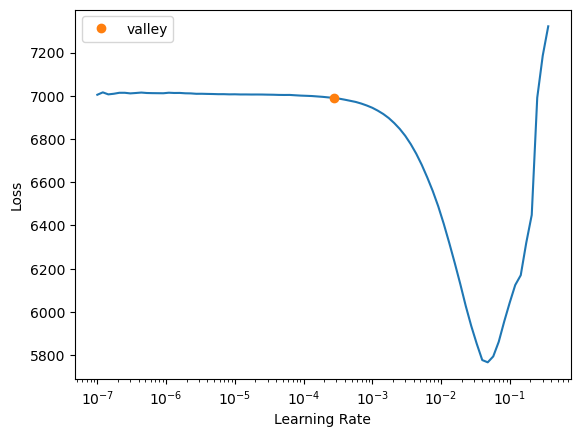

In [8]:
model_name = "TSTPlus"
learn = TSForecaster(X, y, splits, bs=batch_size, batch_tfms=[], arch=model_name, arch_config=dict())
lr = learn.lr_find().valley

epoch,train_loss,valid_loss,time
0,6996.853027,6964.747559,00:16
1,6978.299805,6930.466797,00:17
2,6949.108398,6870.788574,00:17
3,6898.406738,6766.694336,00:17
4,6813.917480,6591.559570,00:17
5,6678.888672,6331.430176,00:17
6,6484.555664,6019.897461,00:17
7,6234.717773,5679.951660,00:17
8,5936.238770,5300.544922,00:17
9,5595.210449,4885.797852,00:17


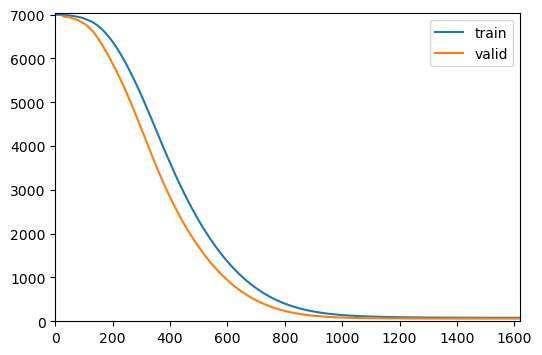

In [9]:
epochs = 60
learn.fit_one_cycle(epochs, lr, cbs=[ShowGraphCallback()])

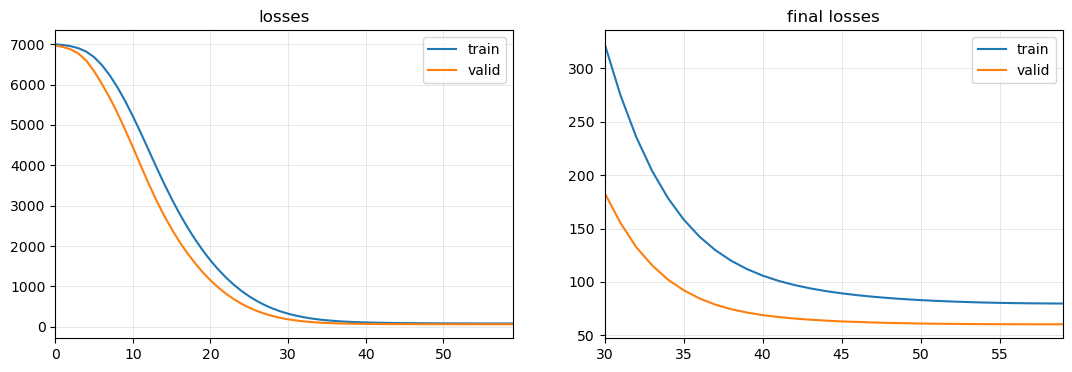

In [11]:
learn.recorder.plot_metrics()

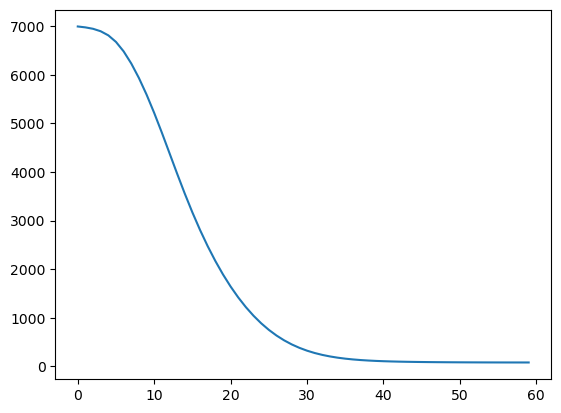

In [12]:
train_loss = [i[0] for i in learn.recorder.values]
import matplotlib.pyplot as plt
plt.plot(train_loss)

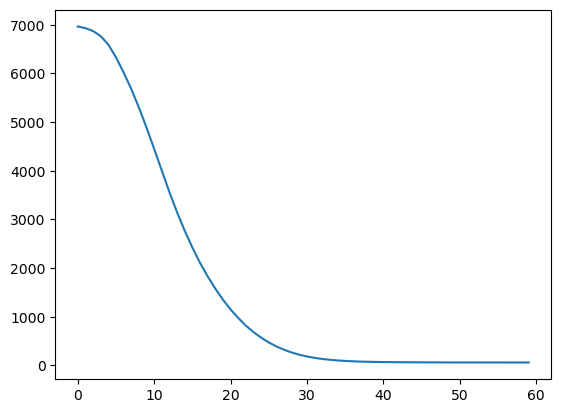

In [13]:
valid_loss = [i[1] for i in learn.recorder.values]
plt.plot(valid_loss)

In [14]:
learn.export(f'time_model/{model_name}_d_{d}_epoch_{epochs}.pkl')